# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.0443898 , -0.16982186, -0.03179038,  0.26222212]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.635702466399802 -2.4972954863086017


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, # Calculating Qs
               targetQs, # targetQs/nextQs
               action_size, hidden_size): # model init for Qs
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    Qs_onehot = tf.multiply(actions_logits[:-1], actions_onehot[1:])
    Qs = tf.reduce_max(Qs_onehot, axis=1)
    
    #loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))
    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # Calculating Qs 
            targetQs=self.targetQs) # alculating targetQs/nextQs

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [30]:
# Training parameters
train_episodes = 2000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [31]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [32]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [33]:
state, reward, action

(array([-0.16512619, -0.81643307,  0.17027349,  1.44282764]), 1.0, 0)

In [34]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            states = np.array([each[1] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})            
            rewarded_actions_logits = np.multiply(actions_logits, np.reshape(rewards, [-1, 1]))
            Qs = np.max(rewarded_actions_logits, axis=1)
    
            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.actions: actions,
                         model.states: states, 
                         model.targetQs: Qs}
            loss, _ = sess.run([model.loss, model.opt], feed_dict)

            # For average loss in one episode/epoch
            loss_batch.append(loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 7.0 Average loss: 0.687626600 Explore P: 0.999208317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 13.0 Average loss: 0.668861270 Explore P: 0.997824394
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9.0 Average loss: 0.635344148 Explore P: 0.996837063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 33.0 Average loss: 0.601565599 Explore P: 0.993487515
-------------------------------------------------------------------------------
----------------------------------------------

-------------------------------------------------------------------------------
Episode: 36 Total reward: 39.0 Average loss: 0.126367882 Explore P: 0.908480446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 45.0 Average loss: 0.115694039 Explore P: 0.904356927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 19.0 Average loss: 0.114036396 Explore P: 0.902570001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 12.0 Average loss: 0.111656189 Explore P: 0.901410414
-------------------------------------------------------------------------------
----------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 44.0 Average loss: 0.103975452 Explore P: 0.824524855
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 27.0 Average loss: 0.098709710 Explore P: 0.822247375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 9.0 Average loss: 0.098033533 Explore P: 0.821435534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 58.0 Average loss: 0.104639761 Explore P: 0.816662160
-------------------------------------------------------------------------------
-----------------------------------------

-------------------------------------------------------------------------------
Episode: 106 Total reward: 27.0 Average loss: 0.118048586 Explore P: 0.750410634
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 107 Total reward: 25.0 Average loss: 0.115641437 Explore P: 0.748488067
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 11.0 Average loss: 0.114478648 Explore P: 0.747602413
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 43.0 Average loss: 0.120346375 Explore P: 0.744364092
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 141 Total reward: 57.0 Average loss: 0.048686858 Explore P: 0.651048388
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 142 Total reward: 43.0 Average loss: 0.057192717 Explore P: 0.648233972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 96.0 Average loss: 0.065083653 Explore P: 0.642073031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 39.0 Average loss: 0.073918700 Explore P: 0.639549789
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 175 Total reward: 31.0 Average loss: 0.048476927 Explore P: 0.546198776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 176 Total reward: 13.0 Average loss: 0.047030430 Explore P: 0.545448623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 53.0 Average loss: 0.045117680 Explore P: 0.542564993
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 11.0 Average loss: 0.046908010 Explore P: 0.541926299
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 209 Total reward: 82.0 Average loss: 0.023019474 Explore P: 0.424844994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 51.0 Average loss: 0.030145586 Explore P: 0.422693399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 51.0 Average loss: 0.029093344 Explore P: 0.420552964
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 41.0 Average loss: 0.030349916 Explore P: 0.418832257
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 243 Total reward: 125.0 Average loss: 0.217381626 Explore P: 0.341658207
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 24.0 Average loss: 0.193863615 Explore P: 0.340830098
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 32.0 Average loss: 0.305398911 Explore P: 0.339740158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 70.0 Average loss: 0.261825085 Explore P: 0.337407294
-------------------------------------------------------------------------------
-----------------------------------

-------------------------------------------------------------------------------
Episode: 277 Total reward: 196.0 Average loss: 0.040087495 Explore P: 0.242922305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 170.0 Average loss: 0.129302427 Explore P: 0.238973195
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Average loss: 0.027874345 Explore P: 0.234439222
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 199.0 Average loss: 0.005729437 Explore P: 0.229995027
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 311 Total reward: 54.0 Average loss: 0.044265009 Explore P: 0.165586982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 312 Total reward: 199.0 Average loss: 0.059157677 Explore P: 0.162506153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 139.0 Average loss: 0.062246881 Explore P: 0.160385943
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 314 Total reward: 14.0 Average loss: 0.111140914 Explore P: 0.160160533
-------------------------------------------------------------------------------
----------------------------------

-------------------------------------------------------------------------------
Episode: 345 Total reward: 135.0 Average loss: 0.059369277 Explore P: 0.113028427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 346 Total reward: 118.0 Average loss: 0.031250972 Explore P: 0.111809655
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 120.0 Average loss: 0.017237406 Explore P: 0.110585181
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 147.0 Average loss: 0.023921508 Explore P: 0.109107483
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 380 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.098376398
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 381 Total reward: 17.0 Average loss: 0.693147242 Explore P: 0.098217464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 382 Total reward: 19.0 Average loss: 0.693147302 Explore P: 0.098041205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 383 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.097733599
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 415 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.090818423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.090616629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.090367104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 38.0 Average loss: 0.693147242 Explore P: 0.090054283
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 450 Total reward: 19.0 Average loss: 0.693147302 Explore P: 0.083193377
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 451 Total reward: 23.0 Average loss: 0.693147182 Explore P: 0.083017924
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 452 Total reward: 45.0 Average loss: 0.693147242 Explore P: 0.082682813
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 453 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.082515834
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 484 Total reward: 32.0 Average loss: 0.693147182 Explore P: 0.076354060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 25.0 Average loss: 0.693147242 Explore P: 0.076181763
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.076016515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.075878026
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 518 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.070376801
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 519 Total reward: 23.0 Average loss: 0.693147182 Explore P: 0.070232071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 520 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.070117738
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 521 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.069991623
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 553 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.065180241
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 554 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.065075498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 555 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.064926995
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.064811770
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 587 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.060139291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 588 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.060044116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.059899199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 590 Total reward: 40.0 Average loss: 0.693147182 Explore P: 0.059695031
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 622 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.055367906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 25.0 Average loss: 0.693147242 Explore P: 0.055250103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 23.0 Average loss: 0.693147182 Explore P: 0.055141633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.055019915
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 656 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.051256346
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 657 Total reward: 31.0 Average loss: 0.693147182 Explore P: 0.051124537
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 658 Total reward: 32.0 Average loss: 0.693147182 Explore P: 0.050989049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 659 Total reward: 29.0 Average loss: 0.693147302 Explore P: 0.050866267
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 691 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.047438701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 692 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.047367635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 693 Total reward: 31.0 Average loss: 0.693147182 Explore P: 0.047248249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 42.0 Average loss: 0.693147242 Explore P: 0.047088426
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 726 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.044110489
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 727 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.044011712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 728 Total reward: 47.0 Average loss: 0.693147182 Explore P: 0.043848847
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 729 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.043777839
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 761 Total reward: 27.0 Average loss: 0.693147242 Explore P: 0.040815103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 762 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.040744310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.040667545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 764 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.040584855
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 795 Total reward: 41.0 Average loss: 0.693147182 Explore P: 0.037907764
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 796 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.037849220
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 797 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.037796356
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 798 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.037743593
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 829 Total reward: 35.0 Average loss: 0.693147242 Explore P: 0.035513429
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 830 Total reward: 21.0 Average loss: 0.693147302 Explore P: 0.035457361
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.035383642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 23.0 Average loss: 0.693147182 Explore P: 0.035322794
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 864 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.033173397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 865 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.033120160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 866 Total reward: 42.0 Average loss: 0.693147242 Explore P: 0.033020956
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.032977258
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 898 Total reward: 35.0 Average loss: 0.693147242 Explore P: 0.030978643
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 899 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.030934635
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.030869838
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.030796921
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 932 Total reward: 41.0 Average loss: 0.693147182 Explore P: 0.029073595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.029025971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 934 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.028967082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 17.0 Average loss: 0.693147242 Explore P: 0.028932972
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 966 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.027409307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 967 Total reward: 43.0 Average loss: 0.693147242 Explore P: 0.027332874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.027272315
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.027225743
-------------------------------------------------------------------------------
------------------------------------

-------------------------------------------------------------------------------
Episode: 1001 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.025890238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1002 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.025856903
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1003 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.025826804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1004 Total reward: 19.0 Average loss: 0.693147302 Explore P: 0.025795182
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1036 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.024326414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1037 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.024282071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1038 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.024243561
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1039 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.024213681
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1070 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.023046305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 40.0 Average loss: 0.693147182 Explore P: 0.022992925
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1072 Total reward: 21.0 Average loss: 0.693147302 Explore P: 0.022964372
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1073 Total reward: 40.0 Average loss: 0.693147182 Explore P: 0.022911326
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1105 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.021728303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1106 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.021687325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1107 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.021653481
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1108 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.021626709
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1140 Total reward: 38.0 Average loss: 0.693147242 Explore P: 0.020645156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1141 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.020607963
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1142 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.020581476
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1143 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.020544506
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1175 Total reward: 37.0 Average loss: 0.693147242 Explore P: 0.019691071
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1176 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.019668807
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1177 Total reward: 51.0 Average loss: 0.693147063 Explore P: 0.019618660
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1178 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.019585053
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1209 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.018827792
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1210 Total reward: 29.0 Average loss: 0.693147302 Explore P: 0.018801348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1211 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.018774107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1212 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.018750448
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1244 Total reward: 27.0 Average loss: 0.693147242 Explore P: 0.018035787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1245 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.018018930
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1246 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.018002107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1247 Total reward: 36.0 Average loss: 0.693147242 Explore P: 0.017972554
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1279 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.017218917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1280 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.017198012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1281 Total reward: 32.0 Average loss: 0.693147182 Explore P: 0.017174298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1282 Total reward: 25.0 Average loss: 0.693147242 Explore P: 0.017155669
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1314 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.016540443
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1315 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.016528028
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1316 Total reward: 43.0 Average loss: 0.693147242 Explore P: 0.016499368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1317 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.016487031
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1348 Total reward: 47.0 Average loss: 0.693147182 Explore P: 0.015920405
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1349 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.015907986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1350 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.015892056
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1351 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.015874993
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1383 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.015407057
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1384 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.015390321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1385 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.015376862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1386 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.015365582
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1417 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.014920966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1418 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.014909661
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1419 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.014900342
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1420 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.014889084
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1451 Total reward: 21.0 Average loss: 0.693147302 Explore P: 0.014502375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1452 Total reward: 36.0 Average loss: 0.693147242 Explore P: 0.014485747
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1453 Total reward: 32.0 Average loss: 0.693147182 Explore P: 0.014470968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1454 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.014459805
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1486 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.014069031
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1487 Total reward: 32.0 Average loss: 0.693147182 Explore P: 0.014055626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.014043881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.014034591
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1521 Total reward: 45.0 Average loss: 0.693147242 Explore P: 0.013675190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1522 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.013664548
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1523 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.013654667
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1524 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.013646271
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1555 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.013350820
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1556 Total reward: 42.0 Average loss: 0.693147242 Explore P: 0.013336442
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1557 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.013327446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1558 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.013319801
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1590 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.013026494
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1591 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.013020145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1592 Total reward: 19.0 Average loss: 0.693147302 Explore P: 0.013014111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1593 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.013005383
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1624 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.012762690
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1625 Total reward: 17.0 Average loss: 0.693147242 Explore P: 0.012757722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1626 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.012751937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1627 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.012746164
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1658 Total reward: 32.0 Average loss: 0.693147182 Explore P: 0.012507045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1659 Total reward: 25.0 Average loss: 0.693147242 Explore P: 0.012500536
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1660 Total reward: 25.0 Average loss: 0.693147242 Explore P: 0.012494043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1661 Total reward: 21.0 Average loss: 0.693147302 Explore P: 0.012488562
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1693 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.012272328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1694 Total reward: 38.0 Average loss: 0.693147242 Explore P: 0.012263483
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1695 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.012257380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1696 Total reward: 18.0 Average loss: 0.693147242 Explore P: 0.012253095
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1727 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.012062678
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1728 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.012055471
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1729 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.012049519
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1730 Total reward: 25.0 Average loss: 0.693147242 Explore P: 0.012044197
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1761 Total reward: 32.0 Average loss: 0.693147182 Explore P: 0.011869190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1762 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.011864522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1763 Total reward: 14.0 Average loss: 0.693147302 Explore P: 0.011861728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1764 Total reward: 36.0 Average loss: 0.693147242 Explore P: 0.011854852
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1795 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.011688440
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1796 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.011684561
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1797 Total reward: 39.0 Average loss: 0.693147182 Explore P: 0.011677836
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1798 Total reward: 29.0 Average loss: 0.693147302 Explore P: 0.011672810
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1829 Total reward: 39.0 Average loss: 0.693147182 Explore P: 0.011540035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1830 Total reward: 36.0 Average loss: 0.693147242 Explore P: 0.011534347
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1831 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.011530210
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1832 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.011525474
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1864 Total reward: 23.0 Average loss: 0.693147182 Explore P: 0.011397109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1865 Total reward: 24.0 Average loss: 0.693147182 Explore P: 0.011393620
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1866 Total reward: 26.0 Average loss: 0.693147242 Explore P: 0.011389863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1867 Total reward: 22.0 Average loss: 0.693147302 Explore P: 0.011386670
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1898 Total reward: 39.0 Average loss: 0.693147182 Explore P: 0.011273928
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1899 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.011269985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1900 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.011267321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1901 Total reward: 34.0 Average loss: 0.693147242 Explore P: 0.011262893
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1933 Total reward: 21.0 Average loss: 0.693147302 Explore P: 0.011157433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1934 Total reward: 27.0 Average loss: 0.693147242 Explore P: 0.011154197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1935 Total reward: 23.0 Average loss: 0.693147182 Explore P: 0.011151430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1936 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.011149015
-------------------------------------------------------------------------------
--------------------------------

-------------------------------------------------------------------------------
Episode: 1967 Total reward: 28.0 Average loss: 0.693147242 Explore P: 0.011058132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 25.0 Average loss: 0.693147242 Explore P: 0.011055384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1969 Total reward: 20.0 Average loss: 0.693147302 Explore P: 0.011053170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1970 Total reward: 30.0 Average loss: 0.693147302 Explore P: 0.011049911
-------------------------------------------------------------------------------
--------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

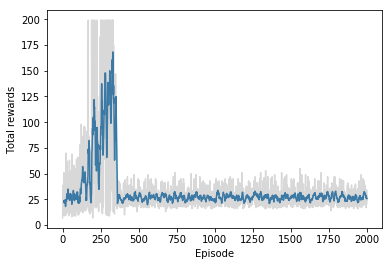

In [36]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

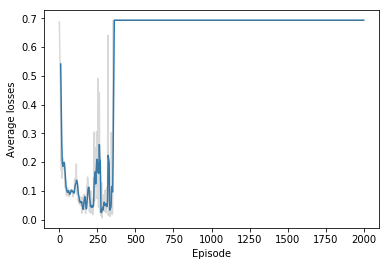

In [37]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [26]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            states = np.array([each[1] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.